# How to crawling?

In [1]:
#import custom module
import nre.con as nc
import nre.util as nu
import pandas as pd
from IPython.display import clear_output 

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [2]:
# loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

cur_region = nc.NRegion('', nc.NLocation(37.49911, 127.065463), '0000000000')

# 검색해서 지역 찾기
while True:
    regions = nu.get_region_list(cur_region.no)
    if len(regions) == 0: break
    for i, region in enumerate(regions): 
        print(i, region)
        
    idx = int(input("원하는 도시 인덱스(exit -1) : "))
    clear_output()
    if idx == -1: break
    cur_region = regions[idx]
    
sector = nu.get_sector(cur_region.loc)

print(sector)

서울시 강남구 대치동 1168010600 loc(37.499110 | 127.065463)


## 매물 조건 생성

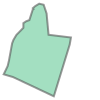

In [14]:
addon = nc.NAddon(
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

sector.map.poly

## 조건과 구역을 이용하여 매물 탐색

In [5]:
things = [] # 매물 기록
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.direction = [dirr] # 매물 방향 선택
    res = nu.get_things(sector, addon)
    
    for v in res:
        if sector.map.is_in(v.loc) is False: # 구역 포함되어있는지
            removed += 1 
            continue 
        v.dir = dirr # 매물 방향 정의
        things.append(v)
    
print('올바른 매물 수', len(things), '제거됨', removed)

올바른 매물 수 432 제거됨 48


## 구역 주변 편의 시설 탐색

In [6]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = []
    res = nu.get_neighborhood(sector.loc, nType)
    
    for r in res:
        if sector.map.is_in(r.loc):
            values.append(r)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 47
METRO 2
INFANT 29
PRESCHOOL 3
SCHOOLPOI 20
HOSPITAL 0
PARKING 68
MART 11
CONVENIENCE 79
WASHING 35
BANK 38
OFFICE 6
Total 338


# 편의시설과 매물 간의 거리 탐색

In [7]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value)

BUS 500
METRO 500
INFANT 750
PRESCHOOL 750
SCHOOLPOI 2000
HOSPITAL 5000
PARKING 500
MART 500
CONVENIENCE 250
WASHING 500
BANK 1000
OFFICE 2000


In [8]:
for thing in things: # 매물
    around = nc.NNeighborAround()
    for nei in neighbors: # 편의시설
        d = nu.distance_between(thing.loc, nei.loc)
        if d <= standard[nei.type]: # meter
            around.increase(nei.type)
    thing.neiAround = around

## 시각화

In [9]:
thing_list = []
around_nei = []

for t in things: 
    thing_list.append(t.get_list())
    around_nei.append(t.neiAround.get_list())

thing_df = pd.DataFrame(data=thing_list ,columns=nc.NThing.HEADER)
nei_df = pd.DataFrame(data=around_nei, columns=nc.NNeighborAround.HEADER)
total_df = pd.concat([thing_df, nei_df], axis=1)

total_df['sector'] = sector.name

total_df.head(5)

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,sector
0,대치풍림아이원1차,아파트,200308,EE,94.58,94.58,94.0,0,210000,210000,...,2,20,0,34,2,10,14,21,6,대치동
1,세영팔래스,아파트,200201,EE,73.77,103.37,103.0,237,175000,200000,...,3,20,0,20,1,10,14,35,6,대치동
2,삼환SOGOOD(주상복합),아파트,200611,EE,107.38,133.52,133.0,359,220000,220000,...,2,20,0,16,2,7,10,32,6,대치동
3,대치대우아이빌명문가(주상복합),아파트,200402,EE,41.88,53.58,41.0,637,31000,38000,...,1,20,0,23,3,14,10,18,6,대치동
4,대치우정에쉐르2(주상복합),아파트,200405,EE,72.18,72.18,72.0,434,99000,130000,...,1,20,0,22,2,14,9,16,6,대치동


In [10]:
nei_df.describe() # 편의시설 접근도

,BUS,METRO,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,432.000000,432.000000,432.000000,432.000000,432.0,432.0,432.000000,432.000000,432.000000,432.000000,432.000000,432.0
mean,10.092593,0.203704,14.388889,1.759259,20.0,0.0,18.500000,2.574074,8.166667,10.259259,24.814815,6.0
std,4.231222,0.446887,4.826134,0.719246,0.0,0.0,6.049295,1.410624,4.180387,3.409745,6.419443,0.0
min,4.000000,0.000000,8.000000,0.000000,20.0,0.0,4.000000,0.000000,0.000000,4.000000,14.000000,6.0
25%,6.000000,0.000000,10.000000,1.000000,20.0,0.0,15.000000,2.000000,6.000000,8.000000,19.000000,6.0
50%,9.000000,0.000000,13.000000,2.000000,20.0,0.0,19.000000,2.000000,7.000000,10.000000,23.500000,6.0
75%,14.000000,0.000000,18.000000,2.000000,20.0,0.0,22.000000,3.000000,11.000000,13.000000,31.000000,6.0
max,18.000000,2.000000,26.000000,3.000000,20.0,0.0,34.000000,6.000000,16.000000,19.000000,37.000000,6.0


## Dataframe 저장

In [11]:
total_df.to_csv('./csv/house_price_data %s.csv' % sector.name, sep=',', na_rep='NaN', index=False)